# Program - Plot DYCOMS domain-avg time series in CERES and TaiESM1 hindcast simulations

**Content**
- Read CERES and TaiESM1 data, and get variables over a region
- Plot time series using matplotlib

**Reference program:**
- zp_04-AM4_CERES_MERRA2-time_series.ipynb
/work/Yi-hsuan.Chen/research/edmf_CM4/manuscript/Sc_diag/plot/zp_04-AM4_CERES_MERRA2-time_series.ipynb

**Author:**
Yi-Hsuan chen

**Date:**
May 2024

In [2]:
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import numpy as np
import xarray as xr
import io, os, sys, types

import yhc_module as yhc
#import read_data as read_data   ## on GFDL PP/AN
import read_data_big as read_data    ## on my Mac

#--- silence dask large chunk and silence the warning.
import dask
dask.config.set(**{'array.slicing.split_large_chunks': False})

xr.set_options(keep_attrs=True)  # keep attributes after xarray operation

ERROR 1: PROJ: proj_create_from_database: Open of /lfs/opt/anaconda3/share/proj failed


## Read CERES, ERA5, and TaiESM variables

### return_varname, Create a function to get variables names

In [3]:
def return_varname(varname_am4):
    """
    ----------------------
    Given variable name in AM4, return corresponding variable names in MERRA-2 and CERES
    ----------------------
    """
    
    func_name = "return_varname"
    
    if (varname_am4 == "swdn_toa"):
        varname_ceres = "toa_solar_all_1h"
        varname_merra2 = "SWTDN"

    elif (varname_am4 == "swabs_toa"):
        varname_ceres = "toa_swabs_1h"
        varname_merra2 = "SWTNT"

    elif (varname_am4 == "swcre_toa"):
        varname_ceres = "toa_swcre_1h"
        varname_merra2 = "swcre_toa"
        
    elif (varname_am4 == "swup_toa_clr"):
        varname_ceres = "toa_sw_clr_1h"
        varname_merra2 = "SWTNTCLR"
        
    elif (varname_am4 == "LWP"):
        varname_ceres = "N/A"
        varname_merra2 = "TQL"

    else:
        varname_merra2 = "N/A"
        varname_ceres = "N/A"
        error_msg = f"WARNING: [{func_name}], [{varname_am4}] counterpart are not supported"
        #error_msg = f"ERROR: [{func_name}] does not support [{varname_am4}]"
        #raise KeyError(error_msg)
    

    return varname_ceres, varname_merra2

#-----------
# do_test
#-----------

do_test=True
#do_test=False

if (do_test):
    varname_am4 = "swup_toa_clr"
    varname_ceres, varname_merra2 = return_varname(varname_am4)

    print(varname_am4+" , "+varname_ceres+" , "+varname_merra2)

swup_toa_clr , toa_sw_clr_1h , SWTNTCLR


### read_ceres_var

In [4]:
def read_ceres_var(varname_am4, region="DYCOMS", do_unit_convert = True):
    choice_ceres = "CERES_July01_30_hourly"
    da_ceres = read_data.read_ceres_data(choice_ceres)

    varname_ceres, varname_merra2 = return_varname (varname_am4)

    #--- read CERES
    if (varname_ceres != "N/A"): 
        var_ceres_ijavg = yhc.get_area_avg(da_ceres.get(varname_ceres), region)
    else:
        var_ceres_ijavg = None

    return var_ceres_ijavg

#-----------
# do_test
#-----------

#do_test=True
do_test=False

if (do_test):
    #varname_am4 = "swcre_toa"
    varname_am4 = "swdn_toa"

    var_ceres_ijavg = read_ceres_var(varname_am4)

### read_era5_var

In [28]:
def read_era5_var (varname_am4, region="DYCOMS"):

    choice="era5_2001July_toa_sw"
    da_era5 = read_data.read_era5_data(choice)
    
    da_era5_siglvl = read_data.read_era5_data(choice="era5_DYCOMS_single_level")
    da_era5_siglvl = yhc.wrap360(da_era5_siglvl, lon='longitude')
    
    if (varname_am4 == "swcre_toa"):
        varname1 = "tsrc"  # clear-sky
        var1_era5 = da_era5.get(varname1)  #.mean("time")
        var1_era5 = (var1_era5*var1_era5.scale_factor + var1_era5.add_offset) / 3600.
        var1_era5.attrs['units']="W/m2"
    
        varname2 = "tsr"  # all-sky
        var2_era5 = da_era5.get(varname2)  #.mean("time")
        var2_era5 = (var2_era5*var2_era5.scale_factor + var2_era5.add_offset) / 3600.
        var2_era5.attrs['units']="W/m2"
    
        var_era5 = var2_era5 - var1_era5
        var_era5.attrs['long_name']="SWCRE"
        
    elif (varname_am4 == "swdn_toa"):
        varname1 = "tisr"  # clear-sky
        var1_era5 = da_era5.get(varname1)  #.mean("time")
        var1_era5 = (var1_era5*var1_era5.scale_factor + var1_era5.add_offset) / 3600.
        var1_era5.attrs['units']="W/m2"
        
        var_era5 = var1_era5
        
    elif (varname_am4 == "LWP"):
        varname1 = "tclw"  # clear-sky
        var1_era5 = da_era5.get(varname1)  #.mean("time")
        var1_era5 = (var1_era5*var1_era5.scale_factor + var1_era5.add_offset) * 1000.
        var1_era5.attrs['units']="g/m2"
        
        var_era5 = var1_era5
    
    elif (varname_am4 == "CLDTOT"):
        varname1 = "tcc"  # clear-sky
        var1_era5 = da_era5_siglvl.get(varname1)  #.mean("time")    
        #print(var1_era5.values)
        var1_era5 = (var1_era5*var1_era5.scale_factor + var1_era5.add_offset)       
        var_era5 = var1_era5
        #print(var_era5.values)
    
    #--- rename ERA5 coordinate names
    var_era5 = var_era5.rename({'longitude':'lon', 'latitude':'lat'})
    var_era5 = var_era5.sortby('lat', ascending=True)
    
    #--- get regional average
    var_era5_ijavg = yhc.get_area_avg(var_era5, region)
    var_era5_ijavg = var_era5_ijavg[0:720]  # July 1-30
    return var_era5_ijavg

#-----------
# do_test
#-----------

#do_test=True
do_test=False

if (do_test):
    #varname_am4 = "swcre_toa"
    varname_am4 = "LWP"
    var_era5 = read_era5_var(varname_am4)
    #print(len(var_era5.values))
    print(var_era5.values)
    
    #choice="era5_2001July_toa_sw"
    #da_era5 = read_data.read_era5_data(choice)

    #da_era5
    #print(var_era5)

### Read TaiESM hindcast simulation data

In [53]:
def read_TaiESM1_hindcast_var (varname_am4, lead_day, 
                               region="DYCOMS",
                               choice="TaiESM1_July01_30_2d_1hr",varname="FSNTOA"):
    
    da_taiesm = read_data.read_TaiESM1_hindcast_data(choice, lead_day)

    if (varname_am4 == "swcre_toa"):
        varname1 = "SWCF"  # clear-sky
        var1 = da_taiesm.get(varname1)  #.mean("time")

    elif (varname_am4 == "swdn_toa"):
        varname1 = "SOLIN"  # clear-sky
        var1 = da_taiesm.get(varname1)  #.mean("time")

    elif (varname_am4 == "LWP"):
        varname1 = "TGCLDLWP"  # clear-sky
        var1 = da_taiesm.get(varname1) * 1000. #.mean("time")
        var1['units']="g/m2"
        #var1 = yhc.unit_convert(var1)
    else:
        var1 = da_taiesm.get(varname_am4)
        
    #--- get regional average
    var1_ijavg = yhc.get_area_avg(var1, region)
    return var1_ijavg

#-----------
# do_test
#-----------

#do_test=True
do_test=False

if (do_test):
    varname_am4 = "LWP"

    var2_taiesm = read_TaiESM1_hindcast_var(varname_am4, lead_day=5)

#var2_taiesm.values

## Plot functions

### Set time coordinate

In [9]:
ntime = 720
tt = np.linspace(0., (ntime-1), ntime)
tt_values = np.arange(0, 720, 24)
tt_labels = np.arange(1,31,1)

### compute_avg

In [10]:
def compuate_avg(var, varname = "VAR", name = "EXP"):
    
    var_avg = var.mean("time")
    var_avg_formant = '{:.1f}'.format(np.array(var_avg))
    
    string= f"exp=[{name}], time-avg [{varname}] = {var_avg_formant}"
    print(string)
    
#-----------
# do_test
#-----------

#do_test=True
do_test=False

if (do_test):
    compuate_avg(var_am4_ijavg, varname_am4, name = "AM4")

### ax_def_xy

In [11]:
def ax_def_xy (ax, var):
    #--- set grids
    ax.grid(True)
    ax.minorticks_on()
    
    ax.set_xlabel("Day in July 2001 (UTC)")
    ax.set_xticks(tt_values)
    ax.set_xticklabels(tt_labels)
    
    #--- set title
    maintitle = "DYCOMS-II domain average"
    ax.set_title(maintitle, loc='center', y=1.05)
    ax.set_title(var.attrs['long_name'], loc='left')
    ax.set_title(var.attrs['units'], loc='right')

    ylabel = var.attrs['long_name'] + " ("+var.attrs['units']+")"
    ax.set_ylabel(ylabel)
    
    #--- set x range
    ax.set_xlim([tt.min(),tt.max()])
    

### plot_night_shading

In [12]:
def plot_night_shading(ax, y_bottom = 0., y_top = 100.):
    
    tt_night_start = np.arange(3, 717, 24)
    tt_night_end = np.arange(12, 720, 24)
    
    print(len(tt_night_start))
    for ii in range(0, len(tt_night_start)):
        ii1 = tt_night_start[ii]
        ii2 = tt_night_end[ii]
        ax.fill_between( [ii1, ii2], y_top, y_bottom, color='gray', alpha=0.2)

### plot_DYCOMS_RFs_period

In [13]:
#gg = np.array([226, 250, 298, 394, 418, 562, 600])
#print(da_am4.time[gg].values)

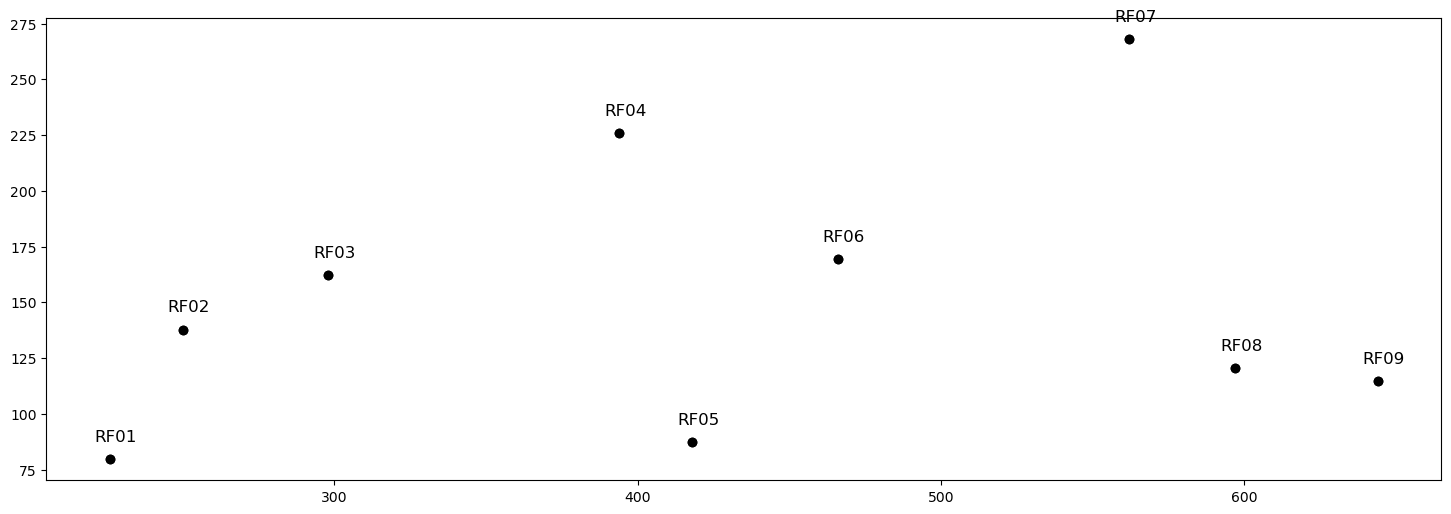

In [14]:
#==============================
def plot_DYCOMS_RFs_period(ax, RFs, line_style = "ko", text_color = 'k'):
    
    #--- RF01-09 (Stevens et al. 2007, Fig. 3), check on 2023/10/04
    LWP_S07_all = np.array([79.6, 137.8, 162.1, 225.8, 87.3, 169.4, 268, 120.5, 114.8]) 
    
    #-- RF01, 02, 03, 04, 05, 07, 08
    LWP_S07 = np.array([79.6, 137.8, 162.1, 225.8, 87.3, 268, 120.5]) 
    
    #ax.invert_yaxis()

    if (RFs == "July_entrain_RFs"):
        
        #--- entraining flights
        #RFs_name = ["RF01", "RF02", "RF03", "RF04", "RF05", "RF07", "RF08"]
        #tt_labels = np.array([226, 250, 298, 394, 418, 562, 600])  # hourly dataset
        
        #--- all flights
        RFs_name =           ["RF01", "RF02", "RF03", "RF04", "RF05", "RF06", "RF07", "RF08", "RF09"]
        tt_labels = np.array([226,    250,    298,     394,    418,   466,    562,    597,     644])  # hourly dataset
        
        #for tt1 in tt_labels:
        for tt in range(0,9):
            tt1 = tt_labels[tt]
            ss1 = RFs_name[tt]
            lwp1 = LWP_S07_all[tt]
            
            ax.plot([tt1,tt1], [lwp1,lwp1], line_style)
            ax.text(tt1-5, lwp1+8, ss1, fontsize=12, color = text_color)

    else:
        error_msg = f"ERROR: RFs [{RFs} is not supported]"
        raise ValueError(error_msg)
    
    #ax.plot([10.4, 11.4], [yy,yy], 'k')
    #ax.text(10.5, yy+10., "RF02", fontsize=10) 

#----------
# do test
#----------
do_test=True
#do_test=False

if (do_test):
    fig, ax1 = plt.subplots(1,1, figsize=(18,6))
    RFs = "July_entrain_RFs"
    
    plot_DYCOMS_RFs_period(ax1, RFs)

### plot_panel_string

In [15]:
def plot_panel_string(axes, 
                      varname = "none", 
                      xx = 1.5, yy = 825, fontsize = 30,
                      panel_strings = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)"], 
                     ):
    #----------------------------
    # plot a string on each ax
    #----------------------------
    
    func_name = "plot_panel_string"
    
    #--- modify xx and yy values given different variables
    if (varname == "swcre_toa"):
        yy = -500
    elif (varname == "LWP"):
        yy = 20
    else:
        xx = 0
    
    #--- get the number of axes
    nax = len(axes)
        
    #--- loop for each ax and plot string
    for i in range(0,nax):
        ax0 = axes[i]
        string1 = panel_strings[i]
        
        #--- plot the string
        ax0.text(xx, yy, string1, fontsize = fontsize)

#-----------
# do_test
#-----------

#do_test=True
do_test=False

if (do_test):
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(6, 6))   # 1 row, 1 column
    
    yy_min = -500
    yy_max = 50
    xx_min = 0
    xx_max = 10
    ax1.plot( [xx_min,xx_max],[yy_min,yy_max],'r-')
    ax2.plot( [xx_min,xx_max],[yy_min,yy_max],'b-')

    axes = [ax1, ax2]
    
    varname = "swcre_toa"
    plot_panel_string(axes, varname = varname, panel_strings = ["gg","ff"]) 

In [16]:
#yhc.lib('pltxy')

### plot_xy_series

exp=[CERES], time-avg [swcre_toa] = -127.2
exp=[ERA5], time-avg [swcre_toa] = -68.1
exp=[day 0], time-avg [swcre_toa] = -98.6
exp=[day 1], time-avg [swcre_toa] = -118.5
exp=[day 2], time-avg [swcre_toa] = -117.0
exp=[day 3], time-avg [swcre_toa] = -111.2
exp=[day 4], time-avg [swcre_toa] = -122.1
exp=[day 5], time-avg [swcre_toa] = -116.6


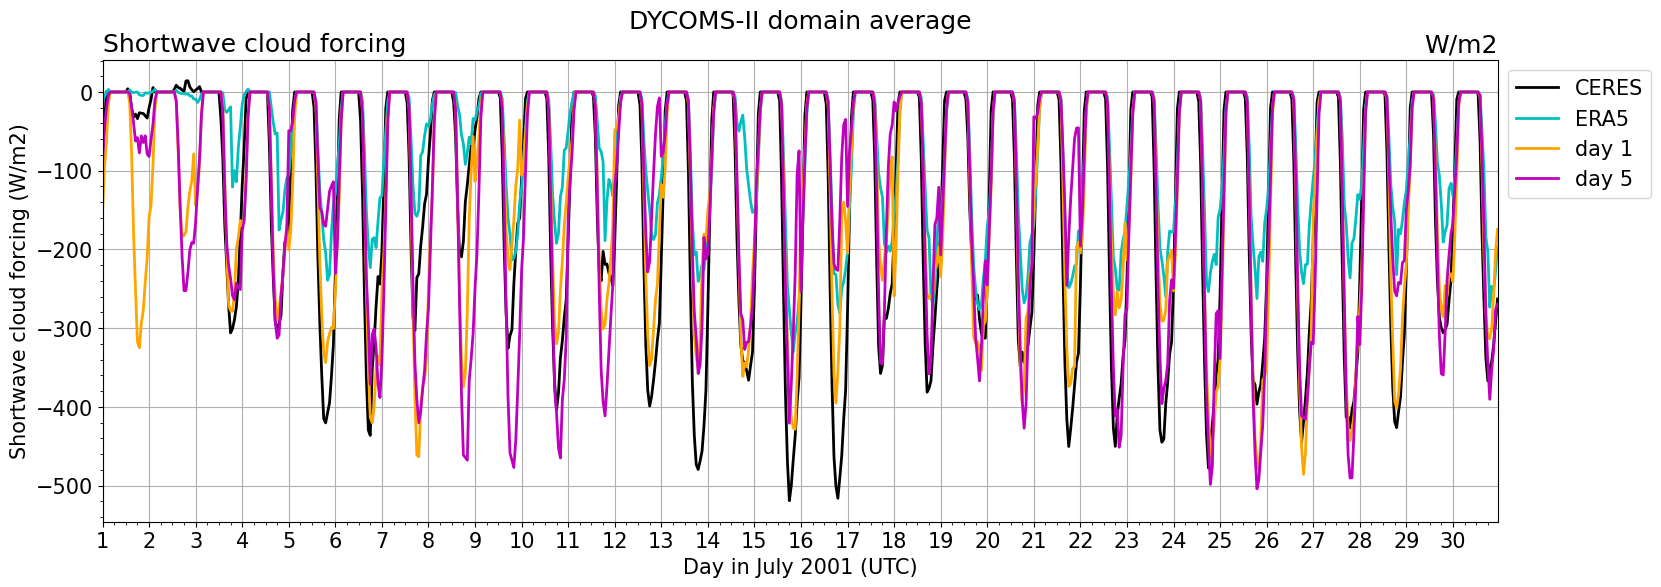

In [68]:
def plot_xy_series(ax, varname_am4, region="DYCOMS",
                   do_plot_ceres=False):

    if (varname_am4 == "swcre_toa" or varname_am4 == "swdn_toa"):
        do_plot_ceres = True
    elif (varname_am4 == "LWP"):
        do_plot_ceres = False

    #--- read vaiables
    var_ceres_ijavg = read_ceres_var(varname_am4)
    var_era5_ijavg = read_era5_var(varname_am4)
    var_taiesm_ld0 = read_TaiESM1_hindcast_var(varname_am4, lead_day=0)
    var_taiesm_ld1 = read_TaiESM1_hindcast_var(varname_am4, lead_day=1)
    var_taiesm_ld2 = read_TaiESM1_hindcast_var(varname_am4, lead_day=2)
    var_taiesm_ld3 = read_TaiESM1_hindcast_var(varname_am4, lead_day=3)
    var_taiesm_ld4 = read_TaiESM1_hindcast_var(varname_am4, lead_day=4)
    var_taiesm_ld5 = read_TaiESM1_hindcast_var(varname_am4, lead_day=5)
    
    #--- set style
    style_ceres = 'k-'; label_ceres = "CERES"
    style_era5 = 'c-' ; label_era5  = "ERA5"
    style_taiesm1_ld0 = 'r-'; label_taiesm1_ld0 = "day 0"
    style_taiesm1_ld1 = 'orange'; label_taiesm1_ld1 = "day 1"
    style_taiesm1_ld2 = 'g-'; label_taiesm1_ld2 = "day 2"
    style_taiesm1_ld3 = 'b-'; label_taiesm1_ld3 = "day 3"
    style_taiesm1_ld4 = 'y-'; label_taiesm1_ld4 = "day 4"
    style_taiesm1_ld5 = 'm-'; label_taiesm1_ld5 = "day 5"

    #--- plot
    if (do_plot_ceres): ax.plot(tt, var_ceres_ijavg, style_ceres, label=label_ceres)
    ax.plot(tt, var_era5_ijavg, style_era5, label=label_era5)
    #ax.plot(tt, var_taiesm_ld0, style_taiesm1_ld0, label=label_taiesm1_ld0)
    ax.plot(tt, var_taiesm_ld1, style_taiesm1_ld1, label=label_taiesm1_ld1)
    #ax.plot(tt, var_taiesm_ld2, style_taiesm1_ld2, label=label_taiesm1_ld2)
    #ax.plot(tt, var_taiesm_ld3, style_taiesm1_ld3, label=label_taiesm1_ld3)
    #ax.plot(tt, var_taiesm_ld4, style_taiesm1_ld4, label=label_taiesm1_ld4)
    ax.plot(tt, var_taiesm_ld5, style_taiesm1_ld5, label=label_taiesm1_ld5)

    ax_def_xy(ax, var_taiesm_ld0)

    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    if (do_plot_ceres): compuate_avg(var_ceres_ijavg, varname_am4, name = label_ceres)
    compuate_avg(var_era5_ijavg, varname_am4, name = label_era5)
    compuate_avg(var_taiesm_ld0, varname_am4, name = label_taiesm1_ld0)
    compuate_avg(var_taiesm_ld1, varname_am4, name = label_taiesm1_ld1)
    compuate_avg(var_taiesm_ld2, varname_am4, name = label_taiesm1_ld2)
    compuate_avg(var_taiesm_ld3, varname_am4, name = label_taiesm1_ld3)
    compuate_avg(var_taiesm_ld4, varname_am4, name = label_taiesm1_ld4)
    compuate_avg(var_taiesm_ld5, varname_am4, name = label_taiesm1_ld5)

    #y_min = -600.
    #y_max = 2000.
    #ax.grid(False, axis = "x")
    #plot_night_shading(ax, y_bottom = y_min, y_top = y_max)  #--- plot night shading

#-----------
# do_test
#-----------

do_test=True
#do_test=False

if (do_test):
    fig, ax = plt.subplots(1,1, figsize=(18, 6))
    #varname_am4 = "LWP"
    varname_am4 = "swcre_toa"

    plot_xy_series(ax, varname_am4)

## Figures 

### swdn_toa

exp=[CERES], time-avg [swdn_toa] = 467.0
exp=[ERA5], time-avg [swdn_toa] = 467.0
exp=[day 0], time-avg [swdn_toa] = 436.5
exp=[day 1], time-avg [swdn_toa] = 469.7
exp=[day 2], time-avg [swdn_toa] = 469.7
exp=[day 3], time-avg [swdn_toa] = 469.7
exp=[day 4], time-avg [swdn_toa] = 469.7


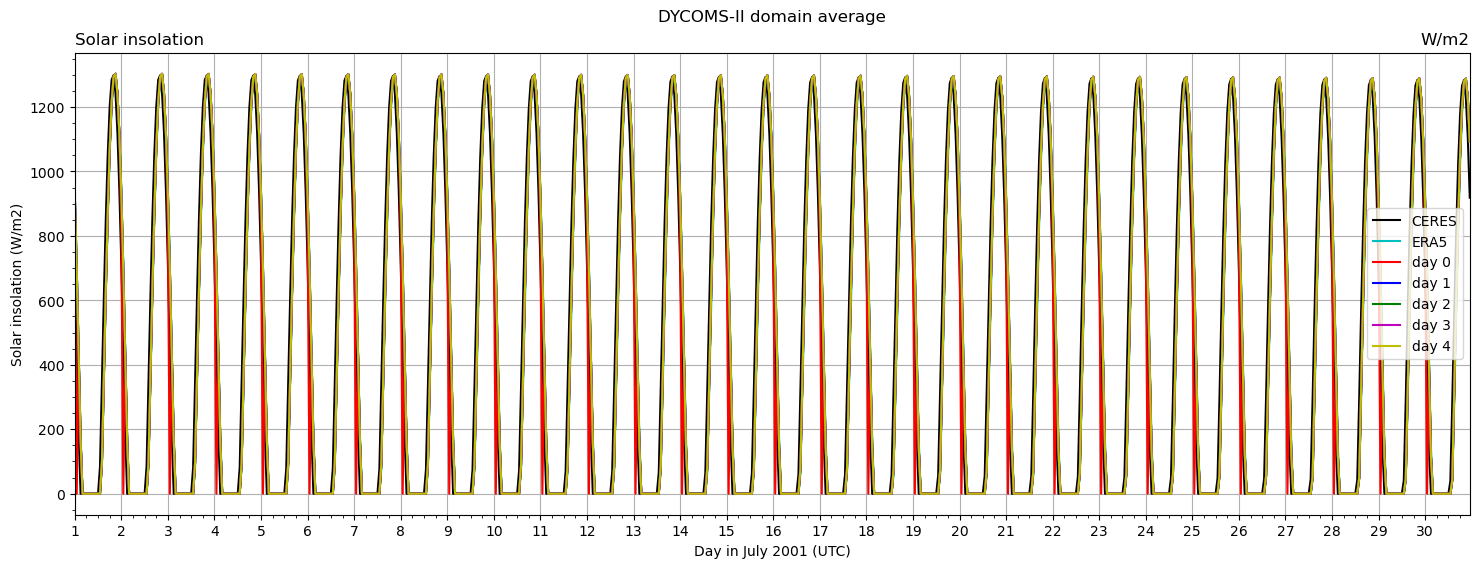

In [20]:
fig, ax = plt.subplots(1,1, figsize=(18, 6))
varname_am4 = "swdn_toa"

plot_xy_series(ax, varname_am4)

### swcre_toa

In [48]:
#yhc.lib('pltxy')

exp=[CERES], time-avg [swcre_toa] = -127.2
exp=[ERA5], time-avg [swcre_toa] = -68.1
exp=[day 0], time-avg [swcre_toa] = -98.6
exp=[day 1], time-avg [swcre_toa] = -118.5
exp=[day 2], time-avg [swcre_toa] = -117.0
exp=[day 3], time-avg [swcre_toa] = -111.2
exp=[day 4], time-avg [swcre_toa] = -122.1


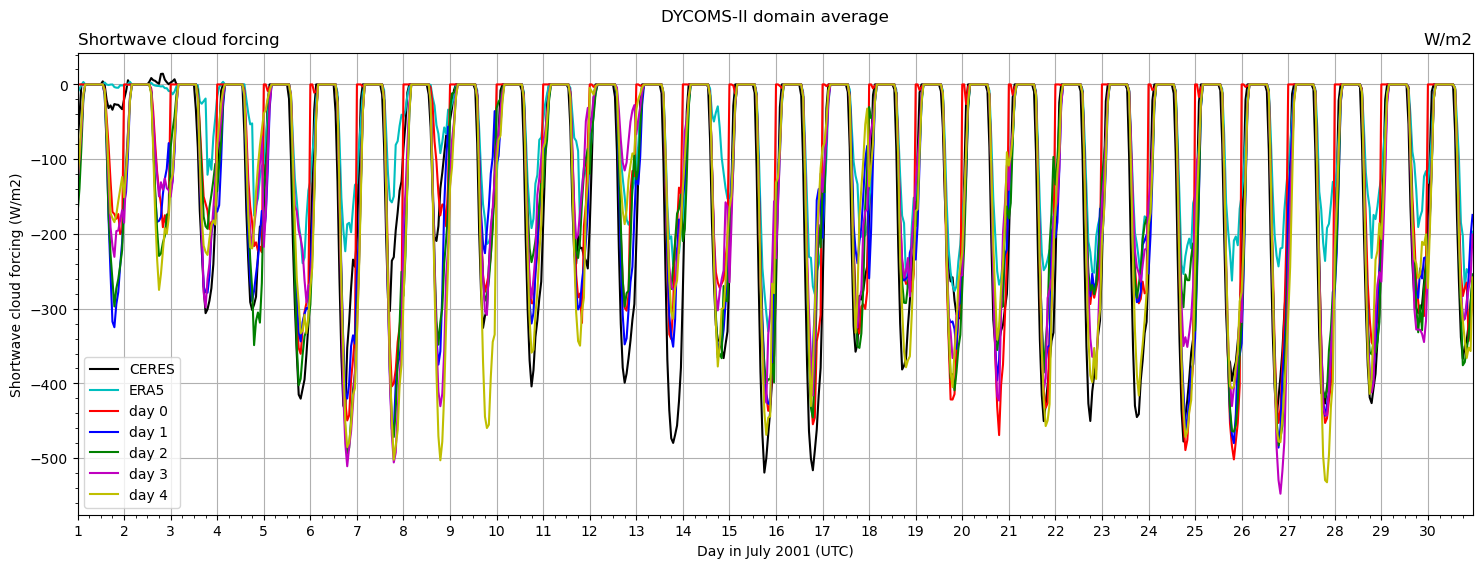

In [21]:
fig, ax = plt.subplots(1,1, figsize=(18, 6))
varname_am4 = "swcre_toa"

plot_xy_series(ax, varname_am4)

### cldtot

exp=[ERA5], time-avg [CLDTOT] = 0.8
exp=[TaiESM1_LeadDay_0], time-avg [CLDTOT] = 0.7
exp=[TaiESM1_LeadDay_1], time-avg [CLDTOT] = 0.9
exp=[TaiESM1_LeadDay_2], time-avg [CLDTOT] = 0.8
exp=[TaiESM1_LeadDay_3], time-avg [CLDTOT] = 0.8
exp=[TaiESM1_LeadDay_4], time-avg [CLDTOT] = 0.8


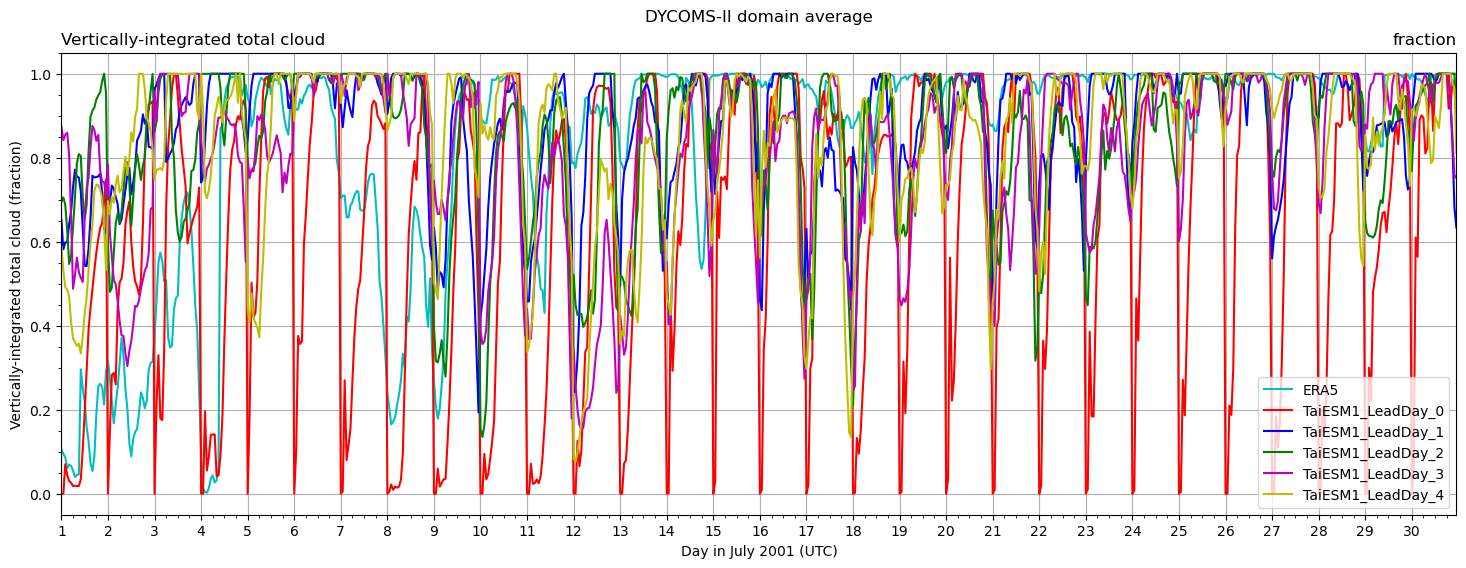

In [35]:
fig, ax = plt.subplots(1,1, figsize=(18, 6))
varname_am4 = "CLDTOT"

plot_xy_series(ax, varname_am4)

### set default plt parameters & use rc function to update 

In [22]:
#--- set default values for font group  
font_default = {
    'size': 15,      # font size 
       }
plt.rc('font', **font_default)

       
#--- set default values for lines group  
lines_default = {
    'linewidth':2,
}
plt.rc('lines', **lines_default)

## Figures

### swcre_toa & LWP

exp=[CERES], time-avg [swcre_toa] = -127.2
exp=[ERA5], time-avg [swcre_toa] = -68.1
exp=[day 0], time-avg [swcre_toa] = -98.6
exp=[day 1], time-avg [swcre_toa] = -118.5
exp=[day 2], time-avg [swcre_toa] = -117.0
exp=[day 3], time-avg [swcre_toa] = -111.2
exp=[day 4], time-avg [swcre_toa] = -122.1
exp=[day 5], time-avg [swcre_toa] = -116.6
30
exp=[ERA5], time-avg [LWP] = 46.8
exp=[day 0], time-avg [LWP] = 39.1
exp=[day 1], time-avg [LWP] = 63.4
exp=[day 2], time-avg [LWP] = 57.0
exp=[day 3], time-avg [LWP] = 53.1
exp=[day 4], time-avg [LWP] = 59.4
exp=[day 5], time-avg [LWP] = 59.9
30


Text(1.5, 270, '(b)')

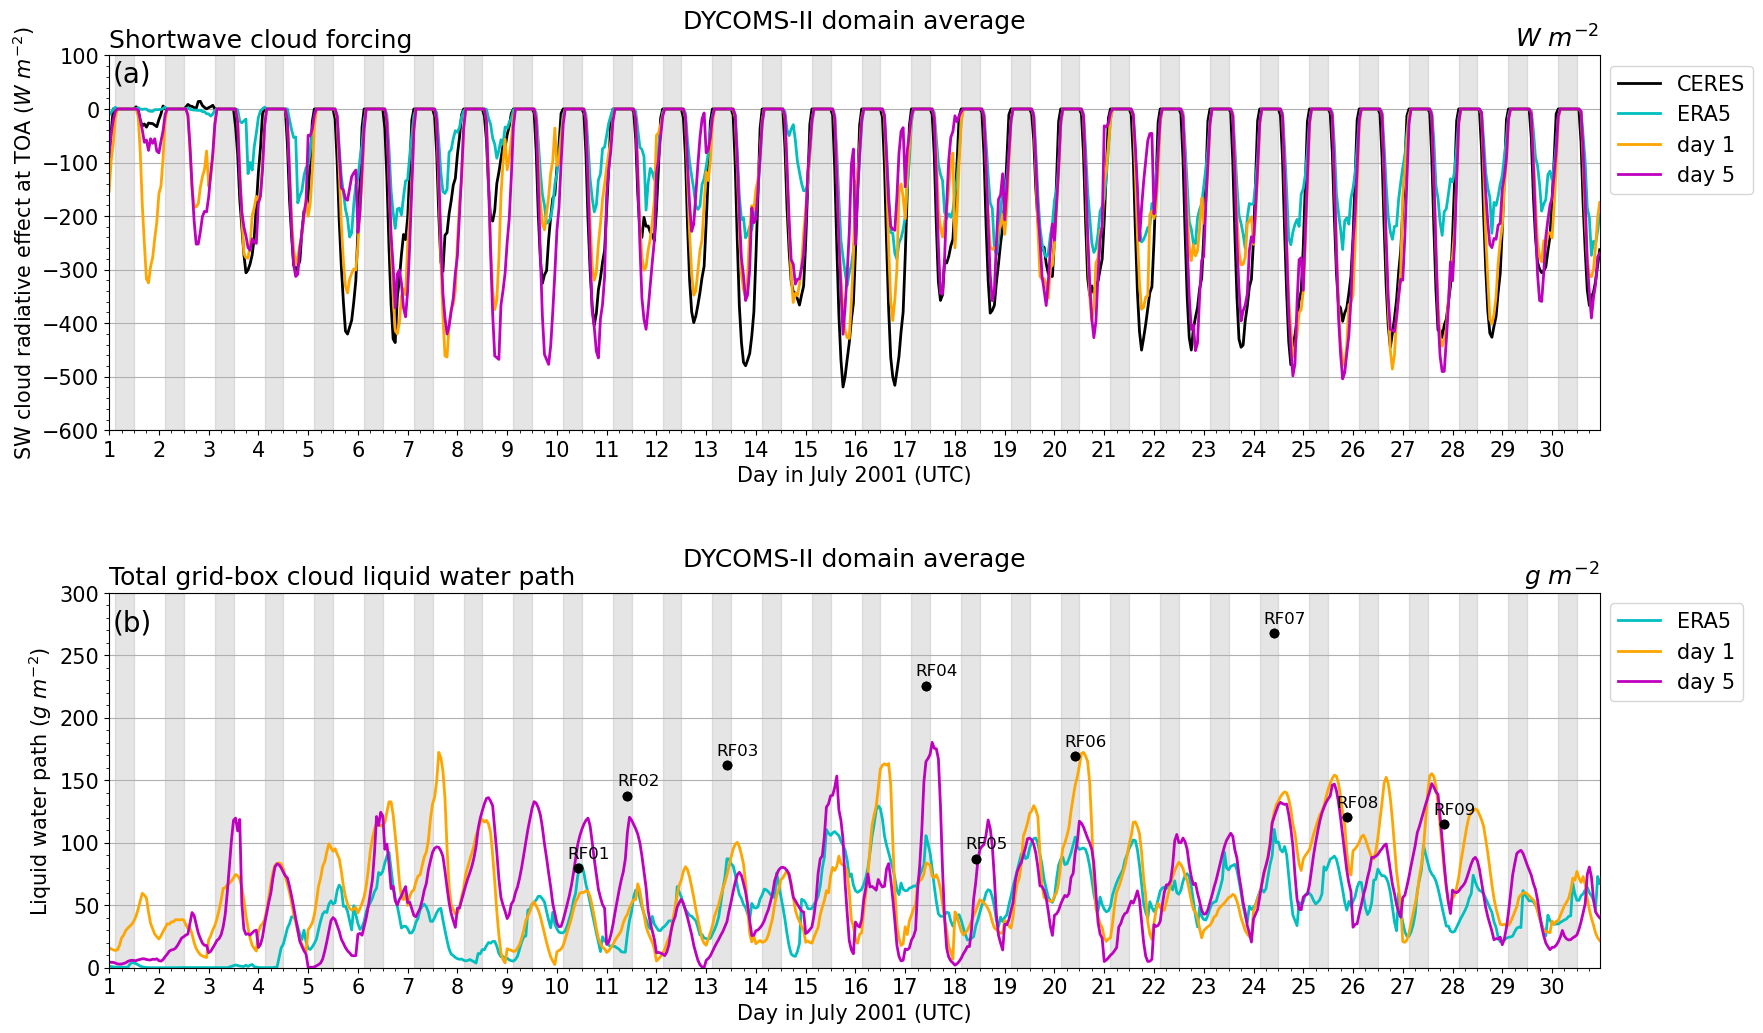

In [69]:
region = "DYCOMS"

fig, (ax2, ax3) = plt.subplots(2,1, figsize=(18, 12))
fig.tight_layout(pad=6.0)

#--- ax2
varname_am4 = "swcre_toa"
plot_datasets = "A_C_M"
plot_xy_series(ax2, varname_am4)
#ax2r"Divergence rate ($10^{-6} s^{-1}$)
ax2.set_title(r"$W \ m^{-2}$", loc='right')
ax2.set_ylabel(r"SW cloud radiative effect at TOA ($W \ m^{-2}$)")

y_min = -600.
y_max = 100.
ax2.grid(False, axis = "x")
ax2.set_ylim([y_min, y_max])
plot_night_shading(ax2, y_bottom = y_min, y_top = y_max)  #--- plot night shading

#--- ax3
varname_am4 = "LWP"
plot_datasets = "A_M"
plot_xy_series(ax3, varname_am4)
ax3.grid(False, axis = "x")
ax3.set_title(r"$g \ m^{-2}$", loc='right')
ax3.set_ylabel(r"Liquid water path ($g \ m^{-2}$)")

lwp_min = 0.
lwp_max = 300.
ax3.set_ylim([lwp_min, lwp_max])
plot_night_shading(ax3, y_bottom = lwp_min, y_top = lwp_max)  #--- plot night shading

#--- plot RFs
RFs = "July_entrain_RFs"
plot_DYCOMS_RFs_period(ax3, RFs)

#plot_panel_string([ax2,ax3], fontsize = 20)
xx = 1.5
yy_swcre = 50.
fontsizt_panel = 20
yy_lwp = 270
ax2.text(xx, yy_swcre, "(a)", fontsize = fontsizt_panel)
ax3.text(xx, yy_lwp, "(b)", fontsize = fontsizt_panel)


### swdn_toa & swcre_toa & LWP

exp=[nudge_AM4], time-avg [swdn_toa] = 467.1
exp=[CERES], time-avg [swdn_toa] = 467.0
exp=[MERRA-2], time-avg [swdn_toa] = 467.5
exp=[ERA5], time-avg [swdn_toa] = 467.0
exp=[nudge_AM4], time-avg [swcre_toa] = -34.6
exp=[CERES], time-avg [swcre_toa] = -127.2
exp=[MERRA-2], time-avg [swcre_toa] = -45.2
exp=[ERA5], time-avg [swcre_toa] = -68.1
exp=[nudge_AM4], time-avg [LWP] = 15.9
exp=[MERRA-2], time-avg [LWP] = 17.9
exp=[ERA5], time-avg [LWP] = 46.8
30


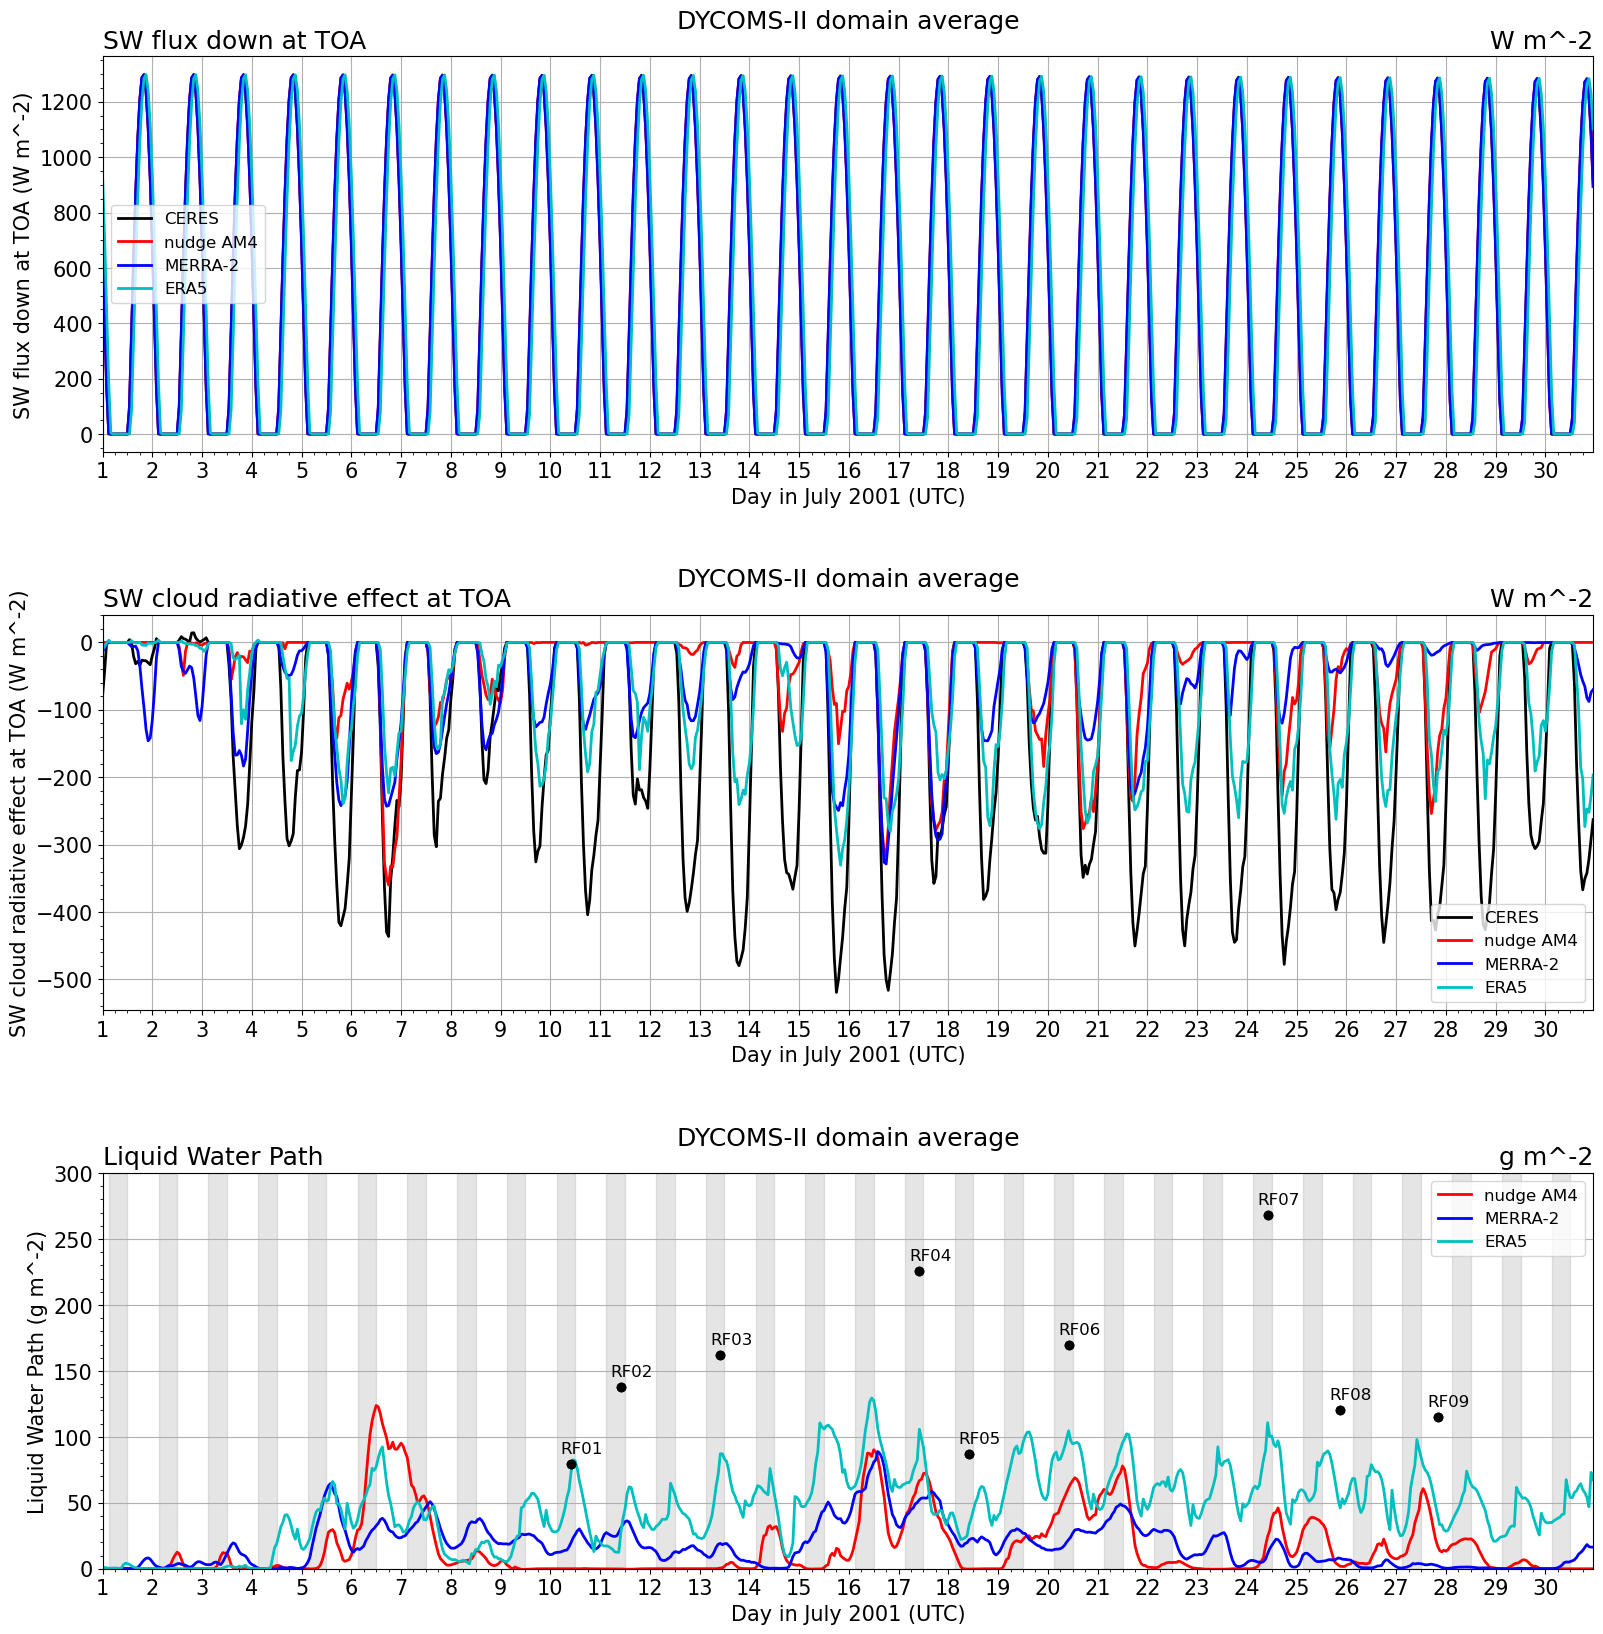

In [15]:
region = "DYCOMS"

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(18, 18))
fig.tight_layout(pad=6.0)

#--- ax1
varname_am4 = "swdn_toa"
plot_datasets = "A_C_M"

plot_xy_series(ax1, region, varname_am4, plot_datasets = plot_datasets)
#plot_night_shading(ax1)

#swabs_min = -5
#swabs_max = 1250
#ax1.set_ylim([swabs_min, swabs_max])
#plot_night_shading(ax1, y_bottom = swabs_min, y_top = swabs_max)

#--- ax2
varname_am4 = "swcre_toa"
plot_datasets = "A_C_M"
plot_xy_series(ax2, region, varname_am4, plot_datasets = plot_datasets)

#--- ax3
varname_am4 = "LWP"
plot_datasets = "A_M"
plot_xy_series(ax3, region, varname_am4, plot_datasets = plot_datasets)
ax3.grid(False, axis = "x")

lwp_min = 0.
lwp_max = 300.
ax3.set_ylim([lwp_min, lwp_max])
plot_night_shading(ax3, y_bottom = lwp_min, y_top = lwp_max)  #--- plot night shading

#--- plot RFs
RFs = "July_entrain_RFs"
plot_DYCOMS_RFs_period(ax3, RFs)


### swdn_toa & swabs_toa

exp=[nudge_AM4], time-avg [swdn_toa] = 467.1
exp=[CERES], time-avg [swdn_toa] = 467.0
exp=[MERRA-2], time-avg [swdn_toa] = 467.5
exp=[ERA5], time-avg [swdn_toa] = 467.0


UnboundLocalError: local variable 'var_era5' referenced before assignment

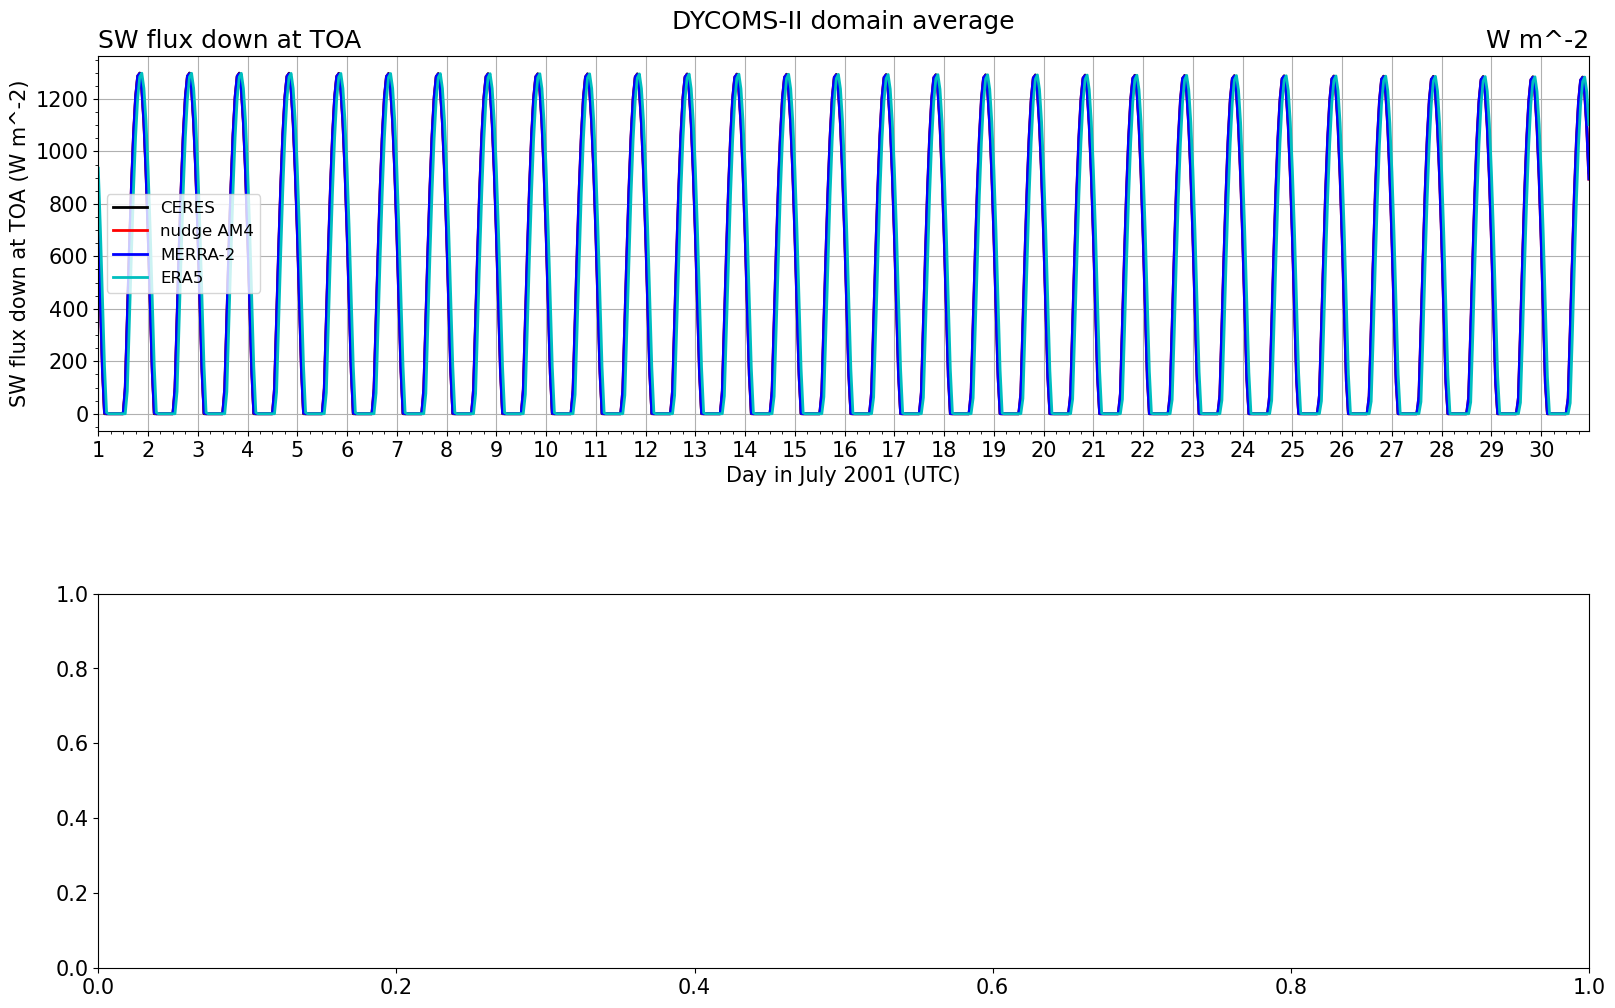

In [16]:
region = "DYCOMS"

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(18, 12))
fig.tight_layout(pad=6.0)

#--- ax1
#varname_am4 = "swabs_toa"
varname_am4 = "swdn_toa"
plot_datasets = "A_C_M"

plot_xy_series(ax1, region, varname_am4, plot_datasets = plot_datasets)
#plot_night_shading(ax1)

#--- ax2
varname_am4 = "swabs_toa"
plot_datasets = "A_C_M"
plot_xy_series(ax2, region, varname_am4, plot_datasets = plot_datasets)


### swup_toa_clr (MERRA-2 is clear-sky, net downward)

In [ ]:
region = "DYCOMS"

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(18, 12))
fig.tight_layout(pad=6.0)

#--- ax1
varname_am4 = "swabs_toa"
plot_datasets = "A_C_M"

plot_xy_series(ax1, region, varname_am4, plot_datasets = plot_datasets)
#plot_night_shading(ax1)

#--- ax2
varname_am4 = "swup_toa_clr"
plot_datasets = "A_C_M"
plot_xy_series(ax2, region, varname_am4, plot_datasets = plot_datasets)

### LWP

In [ ]:
region = "DYCOMS"
plot_datasets = "A"

fig, ax1 = plt.subplots(1,1, figsize=(18, 6))
#fig.tight_layout(pad=6.0)

#--- ax1
varname_am4 = "LWP"
plot_xy_series(ax1, region, varname_am4, plot_datasets = plot_datasets)

plot_night_shading(ax1)
ax1.grid(False, axis = "x")

#tt_night_start = np.arange(3, 717, 24)
#tt_night_end = np.arange(12, 720, 24)